In [790]:
import pandas as pd
from sklearn import preprocessing
import numpy as np
import statsmodels.formula.api as sm
import matplotlib.pyplot as plt
%matplotlib inline
pd.set_option('display.max_columns', 500)


In [791]:
train = pd.read_csv('../data/clean_train_only_complete_cols_chase.csv', parse_dates=['timestamp'], index_col="id")  
test = pd.read_csv('../data/clean_test_only_complete_cols_chase.csv', parse_dates=['timestamp'], index_col="id")
macro = pd.read_csv('../data/macro_brent_contracts_rent3bus.csv',parse_dates=[0])

train = train[train.timestamp>'2011-01-01']
macro = macro[macro.timestamp>'2011-01-01']
macro.reset_index(drop=True,inplace=True)
# macro = pd.read_csv('../data/macro_chase.csv',parse_dates=[0])

In [792]:
train_index = train.index.tolist()
test_index = test.index.tolist()

# cols = ['life_sq','full_sq','floor','max_floor','kitch_sq','product_type',
#         'sub_area','kremlin_km','price_doc','timestamp','price_full']

tr_cols = train.columns.tolist()
te_cols = test.columns.tolist()
cols = list(set(tr_cols).intersection(te_cols))
cols.append('price_doc')

test['price_doc'] = np.nan

df = pd.concat([train[cols].copy(),
                test[cols].copy()],
               ignore_index=False)

df['month'] = df.timestamp.dt.month.astype(object)

In [793]:
macro['month_year'] = pd.PeriodIndex(macro['timestamp'], freq='M').strftime('%m_%y')
df['month_year'] = pd.PeriodIndex(df['timestamp'], freq='M').strftime('%m_%y')

In [794]:
macro_grouped = macro.groupby('month_year').mean()

In [795]:
macro_grouped['date'] = pd.to_datetime(macro_grouped.index.tolist(), format='%m_%y')
macro_grouped.sort_values('date',inplace=True)

In [796]:
macro_grouped['build_contract_index'] = macro_grouped.average_provision_of_build_contract_moscow/macro_grouped.average_provision_of_build_contract_moscow[0]
macro_grouped['brent_index'] = macro_grouped.brent/macro_grouped.brent[0]
macro_grouped['rent_index'] = macro_grouped.rent_price_3room_bus/macro_grouped.rent_price_3room_bus[0]

In [797]:
macro_grouped['adjustment_index'] = macro_grouped[['rent_index','brent_index','build_contract_index']].apply(np.mean,axis=1)

In [798]:
macro_grouped.reset_index(inplace=True)

In [799]:
df = pd.merge(df,macro_grouped[['month_year','adjustment_index']],
              how="left", on="month_year").reset_index(drop=True).set_index(df.index)
# df['real_price_doc'] = df.price_doc / df.rent_index
df['adj_price_doc'] = df.price_doc / df.adjustment_index

In [800]:
# macro['quarter'] = pd.PeriodIndex(macro['Unnamed: 0'], freq='Q').strftime('%qQ%y')
# df['quarter'] = pd.PeriodIndex(df['timestamp'], freq='Q').strftime('%qQ%y')

# df = pd.merge(df,macro[['quarter','adjustment_index']], how="left", on="quarter").reset_index(drop=True).set_index(df.index)
# df['real_price_doc'] = df.price_doc / df.adjustment_index

In [801]:
# moscow = moscow[moscow.date > df.timestamp.min()]
# moscow.reset_index(drop=True,inplace=True)
# moscow['adjustment_index'] = moscow.price / moscow.price[0] 

In [802]:
# moscow = pd.read_csv('../data/moscow_index.csv',header=None,parse_dates=[0])
# moscow.columns = ['date','price']

# df['month_year'] = pd.PeriodIndex(df['timestamp'], freq='M').strftime('%m/%y')
# df = pd.merge(df,moscow[['month_year','# moscow['adjustment_indexadjustment_index'] = moscow.price / moscow.price[0] ']], how="left", on="month_year").reset_index(drop=True).set_index(df.index)

In [803]:
# cleaning up names
df.sub_area = df.sub_area.apply(lambda x: x.replace(" ", "_"))
df.sub_area = df.sub_area.apply(lambda x: x.replace("'", ""))
df.sub_area = df.sub_area.apply(lambda x: x.replace("-", ""))

In [804]:
df['kitch_to_life'] = df.kitch_sq / df.life_sq
df['life_to_full'] = df.life_sq / df.full_sq
df['walk_up_penalty'] = 0
df.loc[(df.floor>4) & (df.max_floor < 6),'walk_up_penalty'] = 1 

## Helper Functions

In [805]:
def addMultiples(df):
    df['price_full'] = df.price_doc / df.full_sq
    df['adj_price_full'] = df.adj_price_doc / df.full_sq
    df['adj_price_class'] = pd.qcut(df.adj_price_full, 5, labels=["E","D","C","B","A"])

In [806]:
addMultiples(df)
print df.price_full.median()
print df.adj_price_full.median()

138254.170315
124184.904397


## Decision Tree Classifier

In [825]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split

In [826]:
# creating a variable for how expensive the property is    
addMultiples(df)

## dropping outliers
outliers = df[df.adj_price_full < 30000].copy()
df.drop(outliers.index,axis=0, inplace=True)
for x in outliers.index.tolist():
    train_index.remove(x)
    

# drop_cols = ['timestamp','price_doc','price_full','okurg_district','sub_area']
keep_cols = ['kremlin_km','floor','full_sq','product_type','full_sq','kitch_sq','max_floor','life_sq','sub_area']

# dataset
df_tcl = df[keep_cols].copy()


# dummify
df_obj = df_tcl.select_dtypes(include=['object']).copy()
df_num = df_tcl.select_dtypes(exclude=['object']).copy()

dummies = pd.get_dummies(df_obj)
df_all = pd.concat([df_num,dummies],axis=1)


In [827]:
tree_clf = DecisionTreeClassifier(max_depth=8)

x = df_all.loc[train_index,:]
y = df.loc[train_index,'adj_price_class']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=42)
tree_clf.fit(x_train,y_train)

1.0 * sum(tree_clf.predict(x_test) == y_test) / len(y_test)


0.5365342279064892

In [828]:
df.loc[test_index,'adj_price_class'] = tree_clf.predict(df_all.loc[test_index,:])

multiples = df.loc[train_index,['adj_price_class','adj_price_full']].groupby('adj_price_class').median().to_dict()


df.loc[test_index,'adj_price_full'] = df.adj_price_class.apply(lambda x: multiples['adj_price_full'].get(x))

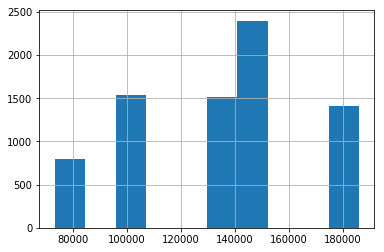

In [829]:
df.loc[test_index,'adj_price_full'].hist()

## Decision Tree Regression
based on price multiple

In [830]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

In [831]:
drop_cols = ['timestamp','adj_price_class','price_doc','adj_price_full','month_year','adj_price_doc','price_full']
df_trg = df.drop(drop_cols,axis=1)

df_obj = df_trg.select_dtypes(include=['object']).copy()
df_num = df_trg.select_dtypes(exclude=['object']).copy()

# df = df[keep_cols]
# df_obj = df.select_dtypes(include=['object'])
# df_num = df.select_dtypes(exclude=['object'])

dummies = pd.get_dummies(df_obj)
df_all = pd.concat([df_num,dummies],axis=1)

df_all = df_all.apply(lambda x: x.astype(float)) 

x = df_all.loc[train_index,:]
y = df.loc[train_index,'adj_price_full']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=42)
    
for i in range(1,15):
    tree_reg = DecisionTreeRegressor(max_depth=i)

    tree_reg.fit(x_train,y_train)
    print i, tree_reg.score(x_test,y_test)

1 0.282507090418
2 0.345443855084
3 0.39331142751
4 0.436677413228
5 0.461965070533
6 0.470215993667
7 0.478183205861
8 0.466660990451
9 0.449029577143
10 0.430587323109
11 0.413280690592
12 0.384263441345
13 0.361821912362
14 0.326927625227


159634.911395


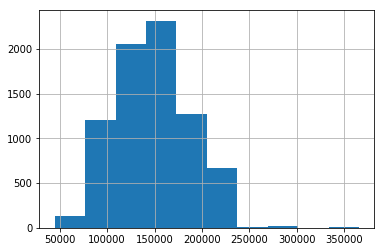

In [832]:
tree_reg = DecisionTreeRegressor(max_depth=7)
tree_reg.fit(x_train,y_train)
df.loc[test_index,'adj_price_full'] = tree_reg.predict(df_all.loc[test_index,:])
df.loc[test_index,'adj_price_doc'] = df.loc[test_index,'full_sq'] * df.loc[test_index,'adj_price_full']
df.loc[test_index,'adj_price_full'].hist()
print df.loc[test_index,'adj_price_full'].median()

133764.512087


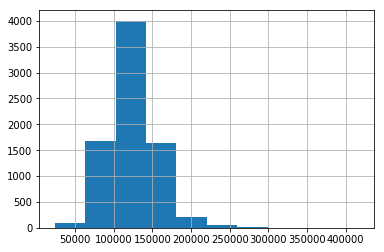

In [854]:
df.loc[test_index,'price_doc'] = df.loc[test_index,'adj_price_doc'] * df.loc[test_index,'adjustment_index']

addMultiples(df)
df.loc[test_index,'price_full'].hist()
print df.loc[test_index,'adj_price_full'].median()

In [855]:
df.loc[test_index,'price_full'].median()

126980.53030848572

In [836]:
# 0.33925
# df.loc[test_index,'price_doc'].to_frame().to_csv('../submissions/decision_tree_price_multiple_052817.csv')

In [837]:
old = pd.read_csv('../submissions/decision_tree_price_multiple_052817.csv')
old.set_index('id',inplace=True)

old['full_sq'] = df.loc[test_index,'full_sq']

old['price_full'] = old.price_doc / old.full_sq

old.price_full.median()

143234.1250509639

## Decision Tree Regressor 
price_doc

In [838]:
drop_cols = ['timestamp','adj_price_class','price_doc','adj_price_full','month_year','adj_price_doc','price_full']
df_trg = df.drop(drop_cols,axis=1)

df_obj = df_trg.select_dtypes(include=['object']).copy()
df_num = df_trg.select_dtypes(exclude=['object']).copy()

# df = df[keep_cols]
# df_obj = df.select_dtypes(include=['object'])
# df_num = df.select_dtypes(exclude=['object'])

dummies = pd.get_dummies(df_obj)
df_all = pd.concat([df_num,dummies],axis=1)

df_all = df_all.apply(lambda x: x.astype(float)) 


x = df_all.loc[train_index,:]
y = df.loc[train_index,'adj_price_doc']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=42)

for i in range(1,15):
    tree_reg = DecisionTreeRegressor(max_depth=i)
    tree_reg.fit(x_train,y_train)
    print i, tree_reg.score(x_test,y_test)

1 0.243826886098
2 0.427576421267
3 0.548300481331
4 0.583586064023
5 0.592888646426
6 0.586548100804
7 0.571272216457
8 0.567284867612
9 0.583334157004
10 0.554857474142
11 0.555765958725
12 0.541896420675
13 0.488918223952
14 0.48411890038


133764.512087


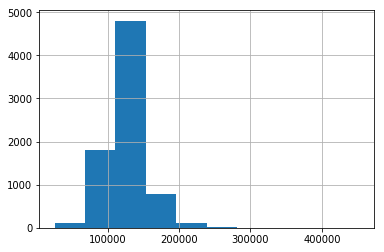

In [847]:
tree_reg = DecisionTreeRegressor(max_depth=5)
tree_reg.fit(x_train,y_train)
df.loc[test_index,'adj_price_doc'] = tree_reg.predict(df_all.loc[test_index,:])
addMultiples(df)
df.loc[test_index,'adj_price_full'].hist()
print df.loc[test_index,'adj_price_full'].median()
# df.loc[test_index,'real_price_full'].hist()

126980.530308


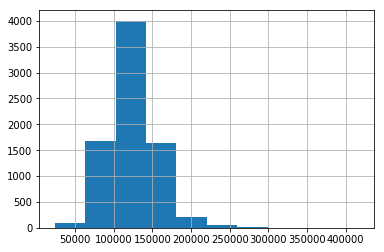

In [845]:
df.loc[test_index,'price_doc'] = df.loc[test_index,'adjustment_index'] * df.loc[test_index,'adj_price_doc']
addMultiples(df)
df.loc[test_index,'price_full'].hist()
print df.loc[test_index,'price_full'].median()

In [853]:
# 0.36993
# df.loc[test_index,'price_doc'].to_frame().to_csv('../submissions/decision_tree_price_doc_rentbrent_index_052917.csv')

In [851]:
df[(df.timestamp>'2014-06-30') & (df.timestamp<'2015-06-30')].price_full.median()

143103.44827586206

In [842]:
# kaggle 0.36506
# df.loc[test_index,'price_doc'].to_frame().to_csv('../submissions/decision_tree_price_doc_052817.csv')

In [843]:
old = pd.read_csv('../submissions/decision_tree_price_doc_052817.csv')
old.set_index('id',inplace=True)

old['full_sq'] = df.loc[test_index,'full_sq']

old['price_full'] = old.price_doc / old.full_sq

old.price_full.median()

144246.7833103968

In [844]:
df.loc[test_index,'price_full'].median()

126980.53030848555